In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.set_random_seed(777)

1.12.0


In [2]:
learning_rate = 0.001
training_epochs = 20
batch_size = 100

In [3]:
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()

In [6]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [7]:
train_init = iterator.make_initializer(train_dataset)
test_init = iterator.make_initializer(test_dataset)

In [8]:
vec_images = tf.reshape(images, [-1, 28, 28, 1])
vec_images = tf.cast(vec_images, tf.float32) / 255.
onehot_labels = tf.one_hot(labels, 10)

In [9]:
drop_rate = tf.placeholder(tf.float32)

In [10]:
L1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(vec_images)
L1 = keras.layers.MaxPool2D(pool_size=[2, 2], padding='SAME', strides=2)(L1)

L2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(L1)
L2 = keras.layers.MaxPool2D(pool_size=[2, 2], padding='SAME', strides=2)(L2)

L3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(L2)
L3 = keras.layers.MaxPool2D(pool_size=[2, 2], padding='SAME', strides=2)(L2)

<tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 4, 4, 64) dtype=float32>

In [11]:
L3_flat = keras.layers.Flatten()(L3)
L4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(L3_flat)
L4 = keras.layers.Dropout(rate=drop_rate)(L4)
hypothesis = keras.layers.Dense(units=10)(L4)

<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 10) dtype=float32>

In [12]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=hypothesis, labels=onehot_labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [13]:
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(onehot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

In [15]:
# train my model
print('Learning started. It takes sometime.')
max_test_acc = 0.
for epoch in range(training_epochs):
    avg_cost = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    
    total_batch = int(train_images.shape[0] / batch_size)
    total_batch_test = int(test_images.shape[0] / batch_size)
    
    sess.run(train_init)
    for i in range(total_batch):
        acc, c, _ = sess.run([accuracy, cost, optimizer], feed_dict={drop_rate:0.4})
        avg_cost += c / total_batch
        avg_train_acc += acc / total_batch
        
    sess.run(test_init)        
    for i in range(total_batch_test):
        acc = sess.run(accuracy, feed_dict={drop_rate:0.})
        avg_test_acc += acc / total_batch_test

    print('Epoch:', '{}'.format(epoch + 1), 'cost =', '{:.8f}'.format(avg_cost), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 cost = 0.20922424 train accuracy =  0.9357 test accuracy =  0.9832
Epoch: 2 cost = 0.05344573 train accuracy =  0.9833 test accuracy =  0.9891
Epoch: 3 cost = 0.03830758 train accuracy =  0.9878 test accuracy =  0.9889
Epoch: 4 cost = 0.03011431 train accuracy =  0.9906 test accuracy =  0.9890
Epoch: 5 cost = 0.02494540 train accuracy =  0.9920 test accuracy =  0.9905
Epoch: 6 cost = 0.01952608 train accuracy =  0.9939 test accuracy =  0.9914
Epoch: 7 cost = 0.01587917 train accuracy =  0.9948 test accuracy =  0.9916
Epoch: 8 cost = 0.01177452 train accuracy =  0.9965 test accuracy =  0.9925
Epoch: 9 cost = 0.01004574 train accuracy =  0.9968 test accuracy =  0.9914
Epoch: 10 cost = 0.00974219 train accuracy =  0.9966 test accuracy =  0.9913
Epoch: 11 cost = 0.00923791 train accuracy =  0.9969 test accuracy =  0.9917
Epoch: 12 cost = 0.00765314 train accuracy =  0.9973 test accuracy =  0.9921
Epoch: 13 cost = 0.00639911 train accuracy =  0.

In [16]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(10), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

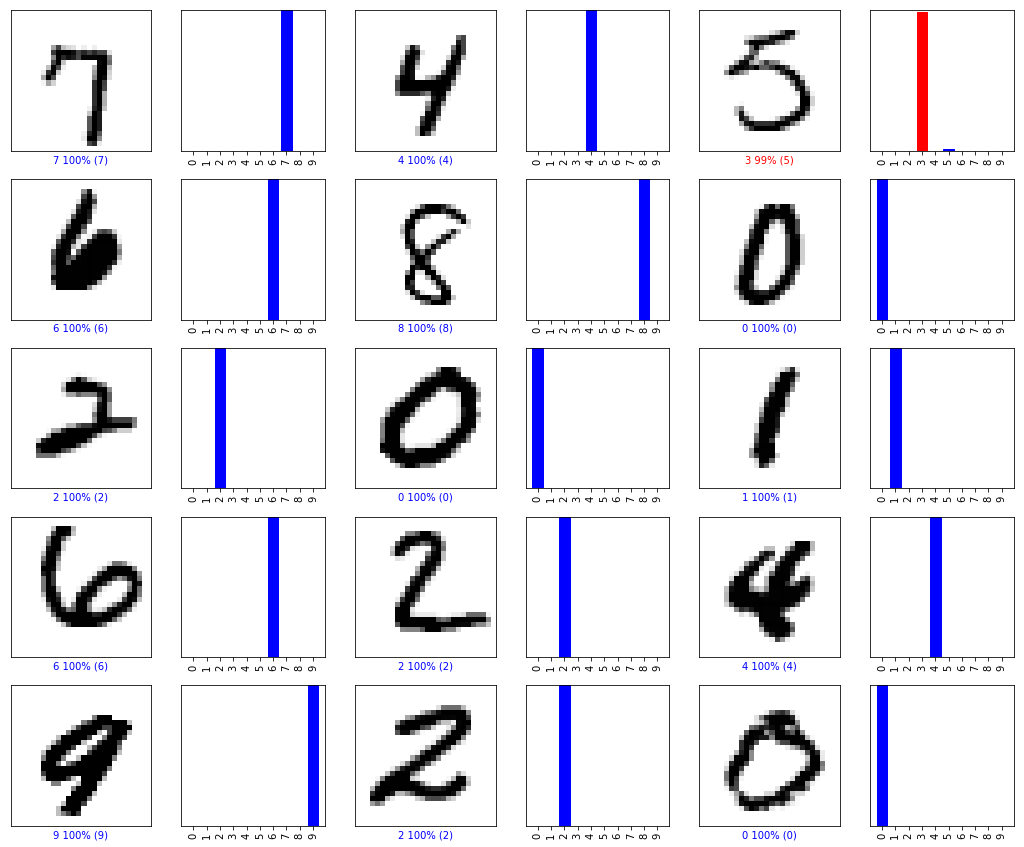

In [17]:
prob = tf.nn.softmax(hypothesis)
#sess.run(test_init)
imgs, lbs, x, y = sess.run([images, labels, vec_images, onehot_labels])
predictions = sess.run(prob, feed_dict={vec_images:x, onehot_labels:y, drop_rate:0.})
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, lbs, imgs)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, lbs)